In [16]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Nov.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Feb.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Oct.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Dec.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Jan.csv


In [17]:
import pandas as pd

# Load October data
df = pd.read_csv('/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Oct.csv')

# Preview the data
df.head()


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4102283 entries, 0 to 4102282
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 281.7+ MB


In [19]:
# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Sort chronologically
df.sort_values('event_time', inplace=True)


In [20]:
df.shape

(4102283, 9)

In [21]:
df['event_type'].value_counts()

event_type
view                1862164
cart                1232385
remove_from_cart     762110
purchase             245624
Name: count, dtype: int64

In [22]:
# Count unique users by event_type
funnel = df.groupby('event_type')['user_id'].nunique()
print(funnel)


event_type
cart                133818
purchase             25762
remove_from_cart     47090
view                388331
Name: user_id, dtype: int64


In [23]:
viewers = funnel.get('view', 0)
cart_users = funnel.get('cart', 0)
purchasers = funnel.get('purchase', 0)

# View → Cart
cart_rate = round((cart_users / viewers) * 100, 2)
# Cart → Purchase
purchase_rate = round((purchasers / cart_users) * 100, 2)
# View → Purchase
overall_rate = round((purchasers / viewers) * 100, 2)

print(f"View → Cart Conversion Rate: {cart_rate}%")
print(f"Cart → Purchase Conversion Rate: {purchase_rate}%")
print(f"View → Purchase Conversion Rate: {overall_rate}%")


View → Cart Conversion Rate: 34.46%
Cart → Purchase Conversion Rate: 19.25%
View → Purchase Conversion Rate: 6.63%


📊 Your Funnel Summary (October 2019 – Cosmetics E-commerce)
Funnel Stage	Unique Users	% Conversion
👀 Viewed a Product	388,331	100%
🛒 Added to Cart	133,818	34.46%
💰 Purchased	25,762	6.63% (overall)
🛒 → 💰 Cart-to-Purchase	19.25%	

🧠 Business Interpretation (for Resume/Client/Portfolio)
🔍 Key Insights:
Only ~6.6% of visitors actually made a purchase

This is your overall funnel efficiency

93%+ users leave without purchasing

~34.5% of viewers add products to cart

This is relatively healthy and shows good product interest

But only 19.2% of those who add to cart actually purchase

This suggests a high cart abandonment rate

Common in cosmetics due to comparison shopping, discount hunting, etc.

🎯 What Would You Recommend to a Client?
As a freelance analyst, your job is to recommend improvements based on insights.

📌 Sample Recommendations:
✉️ Cart Abandonment Emails: Trigger personalized reminders to bring users back

💰 Discount nudges at checkout: For example, “Buy now and save 5%”

🔁 Simplify checkout UX: Fewer clicks → higher conversion

🕐 Retarget users who left at cart stage via ads or SMS

🧪 Run A/B test on product pages with high drop-off to improve layout

📝 Resume / Portfolio Wording:
Conducted funnel drop-off analysis for a cosmetics e-commerce dataset (388K+ users) to simulate a client engagement. Identified a 93% drop-off between product views and purchases, with only 19% of cart users completing a sale. Recommended retention strategies and cart abandonment interventions.



🔍 What is RFM Segmentation?
RFM = Recency, Frequency, Monetary

It helps answer:

Recency: How recently did the customer purchase?

Frequency: How often did they purchase?

Monetary: How much did they spend?

📌 It's commonly used to:

Identify loyal customers

Find churn risks

Target high-value vs. low-value segments



In [24]:
# Filter only purchase events
purchase_df = df[df['event_type'] == 'purchase']


In [25]:
# Snapshot date for recency (simulate 'today')
snapshot_date = purchase_df['event_time'].max()
print("Snapshot date:", snapshot_date)


Snapshot date: 2019-10-31 23:55:35+00:00


In [26]:
# Group by user_id to calculate RFM metrics
rfm = purchase_df.groupby('user_id').agg({
    'event_time': lambda x: (snapshot_date - x.max()).days,  # Recency
    'user_id': 'count',                                       # Frequency
    'price': 'sum'                                            # Monetary
})

# Rename columns
rfm.rename(columns={
    'event_time': 'Recency',
    'user_id': 'Frequency',
    'price': 'Monetary'
}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
user_id,,,
29025780,24,18,41.68
31229488,28,4,14.43
33535391,18,11,138.88
33609704,16,9,31.31
34080306,1,3,16.75


In [27]:
# Create RFM Score columns
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'], 4, labels=[1, 2, 3, 4])
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine into one score
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Score
user_id,,,,,,,
29025780,24,18,41.68,1,4,3,143
31229488,28,4,14.43,1,2,1,121
33535391,18,11,138.88,2,3,4,234
33609704,16,9,31.31,2,3,2,232
34080306,1,3,16.75,4,1,2,412


🎯 Step 5: Interpretation
RFM Score	Meaning
444	🏆 Best customers (recent, frequent, big spenders)
144	New customers (recent, high spend, but first purchase)
411	At-risk (haven’t returned in a while, low value)
111	Lost or low-value

In [28]:
# Count customers by RFM Score
rfm_counts = rfm['RFM_Score'].value_counts().sort_values(ascending=False)
rfm_counts.head(10)


RFM_Score
444    1409
344    1137
111    1125
311    1069
411    1035
211     865
244     762
144     726
333     691
433     658
Name: count, dtype: int64

In [29]:
# Best Customers: R=4, F=4, M=4
best_customers = rfm[rfm['RFM_Score'] == '444']

# Loyal: Frequent + Good Spenders
loyal_customers = rfm[(rfm['F'].astype(int) >= 3) & (rfm['M'].astype(int) >= 3)]

# At Risk: Low Recency, previously good
at_risk = rfm[(rfm['R'].astype(int) <= 2) & (rfm['F'].astype(int) >= 3)]

# Lost: Low everything
lost = rfm[rfm['RFM_Score'] == '111']


In [31]:
print("Best Customers:", best_customers.shape[0])
print("Loyal Customers:", loyal_customers.shape[0])
print("At-Risk Customers:", at_risk.shape[0])
print("Lost Customers:", lost.shape[0])


Best Customers: 1409
Loyal Customers: 9513
At-Risk Customers: 5289
Lost Customers: 1125


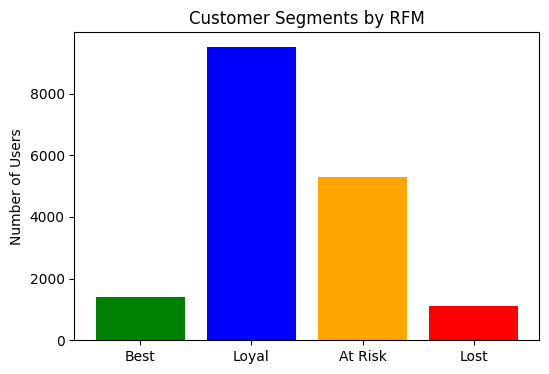

In [32]:
import matplotlib.pyplot as plt

segments = ['Best', 'Loyal', 'At Risk', 'Lost']
counts = [best_customers.shape[0], loyal_customers.shape[0], at_risk.shape[0], lost.shape[0]]

plt.figure(figsize=(6,4))
plt.bar(segments, counts, color=['green', 'blue', 'orange', 'red'])
plt.title("Customer Segments by RFM")
plt.ylabel("Number of Users")
plt.show()


📝 Project Summary — What to Write in GitHub/Resume
Performed RFM segmentation on 25K+ unique purchasers for a simulated cosmetics brand. Identified 444 high-value loyal users and 3+ risk-prone segments (e.g., ‘at risk’ and ‘lost’). Suggested lifecycle-targeted campaigns to re-engage dormant users and reward loyal buyers.
Tools: Python (Pandas, Matplotlib), Segmentation Logic, EDA

📬 Business Recommendations (to “client”):
Segment	Recommendation
🏆 Best Customers	Offer loyalty rewards or early access
💛 Loyal Customers	Personalize offers to maintain engagement
⚠️ At-Risk	Send reactivation offers, ask for feedback
❌ Lost	Use win-back emails or consider them churned